# CMAP Analysis
What I want to check here is what residues are important for an analysis of the role of the activation segment in BRAF.
Firstly I want to train the cmap neural network idea on this, just to say we can.
One of the assumptions we make right now is that this activation segment is BRAF DFG +-20 residues, I would like some biological relevancy to this assumption.
## Current Steps
1. Which residues interact with the activation segment? 

In [3]:

import mdtraj as md
import h5py as h5
import numpy as np
from matplotlib import pyplot as plt
from mdtools.cmaps import ContactMap
from pprint import pprint as pp
hdf = h5.File("./cmaps_braf.h5","r")
braf_topology = md.load_topology("../trajectories/braf_mono/DFGoutACinV1.pdb")

def find_dfg(top):
    # Lets try with just the historic actv segment
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4718462/
    indices = []
    fasta = top.to_fasta()[0]
    D_index = fasta.find("DFG")
    low = D_index + 3 
    hgh = D_index + 26
    residues = top._residues[low:hgh]
    indices = [[atom.index for atom in res.atoms] for res in residues]
    return range(low,hgh)

def chunk_list(start,end,chunks=100):
    n = 0
    i = start
    while True:
        if i >= end:
            break
        elif i + chunks > end:
            chunks = end - i
        chunk = [*range(i,i+chunks)]
        yield chunk
        i += chunks
        
def index2resseq(indices,top):
    if isinstance(indices,int):
        return top._residues[indices].resSeq
    else:
        return [top._residues[i].resSeq for i in indices]

In [8]:
# Load the contact maps
cmaps = {}
for key,group in hdf.items():
    if key != "all_cmaps":
        cmaps[key] = ContactMap(group)

In [9]:
# Get the residues in contact with the activation segment!
from tqdm.notebook import tqdm
contacts = {}
external_contacts = set()
internal_contacts = set()
all_contacts = set()
res_idx = find_dfg(braf_topology)
for key, dataset in cmaps.items():
    cur_contact = set()
    n_frames = dataset.n_frames
    for indices in tqdm(chunk_list(0,n_frames,chunks=500)):
        act_cmap = (dataset[indices][:,res_idx] < 0.8)
        act_contacts = np.transpose(act_cmap.nonzero()[1:])
        for contact in act_contacts:
            contact[0] += res_idx[0]
            contact = tuple(sorted(contact))
            cur_contact.add(contact)
            if (contact[0] in res_idx) and (contact[1] in res_idx):
                internal_contacts.add(contact)
            elif (contact[0] in res_idx) or (contact[1] in res_idx):
                external_contacts.add(contact)
            else:
                print("hmmm")
    contacts[key] = cur_contact
    all_contacts = all_contacts.union(cur_contact)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [140]:
print("NUMBER OF CONTACTS:",len(all_contacts))
print("NUMBER OF INTERNAL CONTACTS:",len(internal_contacts))
print("NUMBER OF EXTERNAL CONTACTS:",len(external_contacts))

NUMBER OF CONTACTS: 1588
NUMBER OF INTERNAL CONTACTS: 265
NUMBER OF EXTERNAL CONTACTS: 1323


In [11]:
# Parse the external contacts into a dict
exts = np.array([*external_contacts])
external_dict = {}
for (i,j) in exts:
    if i in res_idx:
        cur = j
        other = i
    elif j in res_idx:
        cur = i
        other = j
    else:
        print(i,j,"wtf")
    external_dict.setdefault(cur,[])
    external_dict[cur].append(other)
print("Contacts Outside Loop: ", len(external_dict))

Contacts Outside Loop:  162


In [18]:
# Represent all contacts in the BRAF
import socket
import os
import xmlrpc.client as xmlrpclib
import pickle
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint as pp
name = "DFGoutACinV3"
HOST = 'localhost'  # Standard loopback interface address (localhost)
PORT = 9123        # Port to listen on (non-privileged ports are > 1023)
srv = xmlrpclib.ServerProxy('http://localhost:9123')
cmd = f"dss"
srv.do(cmd)
cmd = f"set float_labels, on"
srv.do(cmd)
cmd = f"scene default, store"
srv.do(cmd)
cmd = "bg_color white"
srv.do(cmd)
keys = sorted([k for k in [*external_dict.keys()] if len(external_dict[k]) > 14])
print(len(keys))
for counter,(outer) in enumerate(tqdm(keys)):
    inners = external_dict[outer]
    if len(inners) < 15:
        continue
    outer = index2resseq(int(outer),braf_topology)
    sele1 = f"/{name}//A/{outer}/CA"
    cmd = f"color blue, {sele1}"
    srv.do(cmd)
    cmd = f"label {sele1}, '%s-%s' % (resn,resi)"
    srv.do(cmd)
    cmd = f"center sele1"
    srv.do(cmd)
    for j in inners:
        j = index2resseq(int(j),braf_topology)
        sele2 = f"/{name}//A/{j}/CA"
        cmd = f"distance dist{counter}-{j}, {sele1}, {sele2}"
        srv.do(cmd)
        cmd = f"label {sele2}, '%s-%s' % (resn,resi)"
        srv.do(cmd)
        cmd = f"color red, {sele2}"
        srv.do(cmd)
    cmd = f"scene contacts_to_{outer}, store"
    srv.do(cmd)
    cmd = f"color green, {name}"
    srv.do(cmd)
    cmd = f"hide labels, {sele1}"
    srv.do(cmd)
    for j in inners:
        j = index2resseq(int(j),braf_topology)
        sele2 = f"/{name}//A/{j}/CA"
        cmd = f"hide labels, {sele2}"
        srv.do(cmd)
        cmd = f"disable dist{counter}-{j}"
        srv.do(cmd)


34


  0%|          | 0/34 [00:00<?, ?it/s]

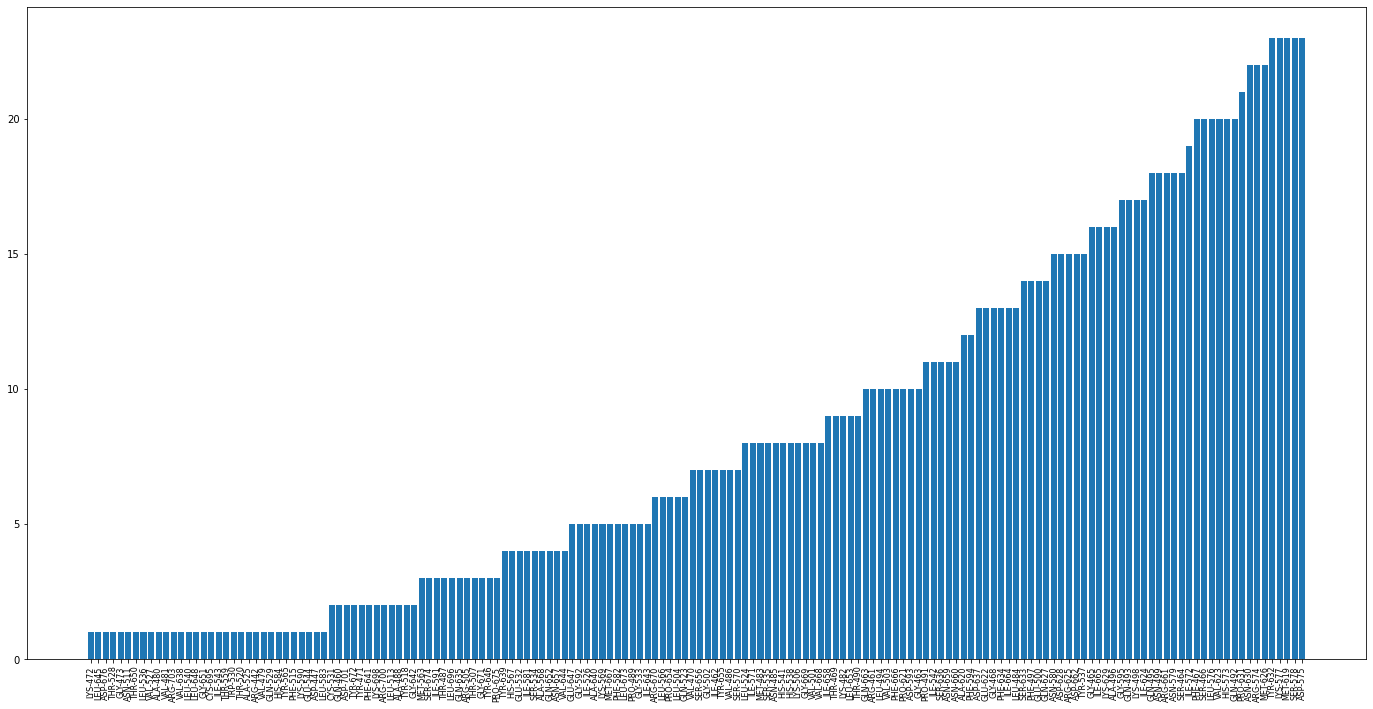

In [192]:
"""
This is with 8 Angstroms,maybe try smaller!
"""
keys = []
bars = []
for key,value in external_dict.items():
        keys.append(f"{braf_topology._residues[key].name}-{braf_topology._residues[key].resSeq}")
        bars.append(len(value))
keys = np.take_along_axis(np.array(keys),np.argsort(bars),0)
bars = np.take_along_axis(np.array(bars),np.argsort(bars),0)
xs = [i+0.1 for i in range(len(keys))]
fig, ax = plt.subplots(1,figsize=(24,12))
plt.bar(xs,bars,tick_label=keys)
lbls = ax.set_xticklabels(keys,rotation=90,fontsize=8)

In [ ]:
## np.unique(np.array([*external_contacts]))
# exts = np.array([*external_contacts])
# for cont in exts:
#     print(find_residues(cont,braf_topology))

In [190]:
np.take_along_axis(np.array(keys),np.argsort(bars),0)

array([ 34, 207, 238,  90,  35,  73, 212,  98,  89,  42,  43, 265, 200,
       102, 210, 213, 257, 105, 121,  92,  82,  87,   4,  41,  91, 146,
       127,  77, 152, 106,   9, 145,  93,  22, 263, 234,  33, 203, 260,
       262,  75,  50,  80, 204, 125, 236, 153,  49, 258, 197,  67,  69,
       233, 208, 237, 201, 129,  94, 143,  96, 130, 214, 219, 206, 209,
       154,  88, 202, 131, 229, 144, 235,  51,  95, 205, 232, 128, 216,
        66,  85,  32, 218,  64,  24, 217,  48, 132,  86, 133,  45,  97,
        47, 103, 100,  68, 231,  63, 230, 220,  31,  44, 215,  52, 225,
        23,  56,  65, 228, 183, 155,  25,  53, 104, 198, 221, 222, 182,
       156, 199, 184,  30, 196, 226,  46, 195,  59,  62, 189, 142, 190,
       187, 224,  99,  27, 227, 191,  58, 157,  55,  60, 186,  57,  61,
       223, 141,  26, 134,  29,  28, 138, 185, 135,  54, 193, 192, 136,
       188, 194, 139, 181, 140, 137])

In [86]:
newic = set()
for ic in internal_contacts:
    if abs(ic[0] - ic[1]) <= 3:
        newic.add(ic)
print(len(newic))

154


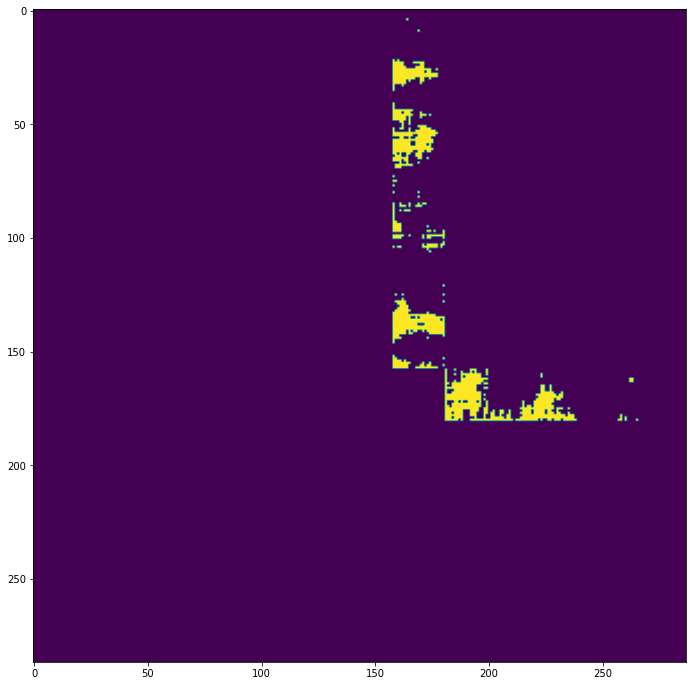

In [142]:
example_matrix = np.zeros((cmap[0][0].shape))
plt.figure(figsize=(12,12))
for (i,j) in external_contacts:
    example_matrix[i,j] = 1
#     example_matrix[j,i] = 1
plt.imshow(example_matrix)

(40, 287)

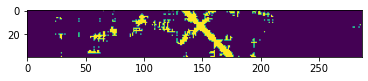

In [118]:
# all_contacts
plt.imshow(act_cmap[0])
act_cmap[0].shape
# np.transpose((cmap[0] < .8).nonzero())

In [5]:
Xcmap = cmap[0]
np.min(Xcmap), np.max(Xcmap)

(0.0, 5.69581413269043)

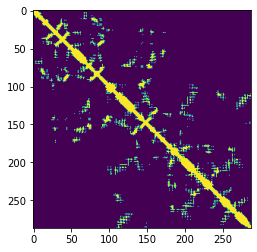

In [28]:
cmap = cmaps[key]
plt.imshow(Xcmap[0] < .8)

In [ ]:
res_idx = find_dfg(braf_topology)
Xcmap[135:175,135:175].shape

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(Xcmap[res_idx] < .8)
plt.colorbar()
Xcmap[res_idx].shape

In [7]:
res_idx

NameError: name 'res_idx' is not defined

In [8]:
cmap[[*range(2)]].shape

(2, 287, 287)

In [9]:
cmap.indices

NameError: name 'self' is not defined

In [ ]:
order = np.unravel_index(np.argsort(Xcmap,axis=None), Xcmap.shape)
Xcmap[order[0][-1],order[1][-1]]
res_idx

In [12]:
cmap[[*range(200)]].shape

(200, 287, 287)

In [10]:
cmap.dataset[[1,2,3]].shape

(3, 41041)

In [24]:
a = cmap[[*range(500)]]

In [25]:
a.shape

(500, 287, 287)

In [39]:
sorted((6,5))

[5, 6]

In [43]:
a = set((1,2,4,5))
b = set((0,2,4,5))
a.union(b)

{0, 1, 2, 4, 5}

/home/sam/.pyenv/versions/3.6.9/envs/md-work-3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  """Entry point for launching an IPython kernel.


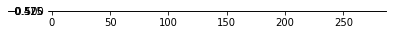

In [198]:
plt.imshow(cmap[0][0][5:10][5:10])

In [201]:
cmap[0][0][5:10,5:10].shape

(5, 5)

In [211]:
def ttv_split_indices(length,training=0.8,
                        test=0.1,
                        validation=0.1):
    """
    Given the length of a 1D data array, it converts to
    the indices required for a training, test, validation split.
    Returns as 3 lists because this makes sense for now
    """
    if training + test + validation != 1:
        print("Total split must add up to 1")
        raise ValueError
    indices = [*range(length)]

    training = int(training*length)
    test = int(test*length)
    validation = int(validation*length)
    total = training+test+validation
    if total != length:
        training += length - total
    training = np.choices()
    
ttv_split_indices(1333)

1333 1067 133 133 1333


In [215]:
length = 1500
indices = [*range(length)]
np.random.Generator.choice(indices,size=(1000),replace=False)
indices = [i]


AttributeError: module 'numpy.random' has no attribute 'Generator'

In [218]:
from numpy.random import Generator

ImportError: cannot import name 'Generator'

In [223]:
idx = [1,2,3,4,5,6,7]
print(idx)
c = np.random.choice(idx,3)
[idx.remove(i) for i in c]
idx

[1, 2, 3, 4, 5, 6, 7]


[1, 2, 4, 7]

In [221]:
a = []
dir(a)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']